# Analisi delle varianti di Rprop per la classificazione del dataset MNIST
Il presente quaderno Jupyter fornisce un ambiente interattivo per l'esplorazione e l'addestramento di reti neurali per il riconoscimento delle cifre del dataset MNIST. Con questo quaderno, gli utenti possono:


### Sperimentare con diverse configurazioni di Reti Neurali
Il quaderno offre la flessibilità di sperimentare con una vasta gamma di configurazioni di reti neurali. Gli utenti possono definire il numero di strati nascosti, il numero di neuroni per strato e le funzioni di attivazione desiderate per costruire la loro rete neurale.


### Personalizzare i parametri di addestramento
Gli utenti possono personalizzare i parametri di addestramento come il numero di epoche, il tasso di apprendimento e la suddivisione del set di addestramento. Inoltre, possono specificare il numero di run, ovvero quante volte desiderano ripetere l'addestramento per una determinata configurazione di rete e algoritmo di ottimizzazione.


### Testare diversi algoritmi di ottimizzazione Rprop
Il quaderno include implementazioni di diversi algoritmi di ottimizzazione, tra cui varianti di Rprop come Rprop-, Rprop+, iRprop-, e iRprop+. Gli utenti possono confrontare le prestazioni delle reti neurali addestrate con questi diversi algoritmi di ottimizzazione.


### Valutare le Prestazioni delle Reti Neurali
Il quaderno fornisce un'analisi dettagliata delle prestazioni delle reti neurali addestrate, inclusi l'errore sui set di addestramento e di validazione, l'accuratezza sui set di addestramento, di validazione e di test e il tempo di esecuzione. Inoltre, vengono calcolate la media e la varianza delle metriche di prestazione su più run, consentendo agli utenti di valutare la stabilità e la consistenza delle configurazioni di rete e algoritmi di ottimizzazione.


## Contenuti
1. Estrazione e preparazione del dataset MNIST
2. Creazione delle reti neurali originarie
3. Addestramento delle reti neurali con diverse varianti di Rprop
4. Valutazione delle prestazioni attraverso grafici
5. Test delle reti addestrate su immagini del test set


N.B: la variabile *number_of_runs* deve essere maggiore di 0.


In [1]:
from uninaannpy import neural_network as nn
from uninaannpy import error_functions as ef
from uninaannpy import activation_functions as af
from uninaannpy import datasets as ds

import numpy as np
import pandas as pd

# Legge csv con pandas
train_data = pd.read_csv('data/mnist_train.csv')
test_data = pd.read_csv('data/mnist_test.csv')

# Ottiene array per il training e il test
train_array = np.array(train_data)
test_array = np.array(test_data)

# Estrapola il numero di righe e di colonne di train e test
train_rows, train_cols = train_array.shape 
test_rows, test_cols = test_array.shape  

# Mescola casualmente i dati prima di suddividerli in set di sviluppo e training
np.random.shuffle(train_array)  
#Calcola percentuale dati per il validation set
validation_percentage = 0.20
val_index = int(np.ceil(train_rows * validation_percentage))

# Distribuzione training, validation e test set
train_in, train_labels = ds.get_mnist_training(train_array, val_index)
validation_in, validation_labels = ds.get_mnist_validation(train_array, val_index)
test_in, test_labels = ds.get_mnist_test(test_array)

In [2]:
## Creazione rete neurale

# Assegna funzioni di attivazione per ogni strato della rete
hidden_activation_functions = [af.leaky_relu]

# Assegna numero di neuroni per ogni strato
hidden_layers = [128]
#Assegna della funzione di attivazione e di errore per l'ultimo strato della rete
output_activation_function = af.identity
error_function = ef.cross_entropy_softmax

# Estrae dimensione input e target
input_layer_size = train_in.shape[0]
output_layer_size = train_labels.shape[0]

epochs = 35
learning_rate = 0.00001
number_of_runs = 500 # Deve essere maggiore di 0!

nets = []

for i in range(number_of_runs):
    hidden_activation_functions = [hidden_activation_functions[0]]
    net = nn.NeuralNetwork(hidden_activation_functions, output_activation_function, error_function,
                input_layer_size, hidden_layers, output_layer_size)
    nets.append(net)

In [3]:
from uninaannpy.neural_network import RpropType

# Inizializza una lista vuota per memorizzare i risultati
std_metrics_list = []
std_trained_nets = []

for i in range(number_of_runs):
    std_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training Rprop standard
    std_metrics = std_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.STANDARD)
    std_trained_nets.append(std_training_net)
    std_metrics_list.append(std_metrics)




Run numero 1 


Epoca: 0/2   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.06481,       Training Loss: 110901.67617;
    Validation Accuracy: 0.06409,     Validation Loss: 27751.76025


Epoca: 1/2   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.06956,       Training Loss: 110132.20984;
    Validation Accuracy: 0.07001,     Validation Loss: 27558.4527


Epoca: 2/2   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.15861,       Training Loss: 105445.84946;
    Validation Accuracy: 0.15835,     Validation Loss: 26411.68392

L'addestramento ha impiegato 0.54891 secondi per eseguire.



Run numero 2 


Epoca: 0/2   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.09773,       Training Loss: 110678.10719;
    Validation Accuracy: 0.09626,     Validation Loss: 27679.10406


Epoca: 1/2   Rprop utilizzata: RpropType.STANDARD
    Training Accuracy: 0.0979,       Training Loss: 110438.35754;
    Validation Accuracy: 0.09626,     Validat

In [4]:
import numpy as np

std_metrics_mean = [[] for _ in range(len(std_metrics))]
std_metrics_variance = [[] for _ in range(len(std_metrics))]

for metric in range(len(std_metrics_mean) - 1):
    for epoch in range(epochs + 1):
        metric_mean, metric_variance, max_value = 0, 0, 0
        min_value = 99999
        for run in range(number_of_runs):
            # Calcola la media per questa epoca e questa metrica attraverso tutte le run
            metric_mean += std_metrics_list[run][metric][epoch] / number_of_runs
        # Aggiunge la media alla lista delle medie della metrica corrispondente
        std_metrics_mean[metric].append(metric_mean)
        
        for run in range(number_of_runs):
            # Calcola la varianza per questa epoca e questa metrica attraverso tutte le run
            metric_variance += pow(std_metrics_list[run][metric][epoch] - metric_mean, 2) / number_of_runs
        # Calcola la varianza normalizzata rispetto alla media, per poter confrontare reti diverse
        norm_variance = metric_variance / metric_mean
        # Aggiunge la media alla lista delle medie della metrica corrispondente
        std_metrics_variance[metric].append(norm_variance)

time_mean, time_variance = 0, 0
for run in range(number_of_runs):
    # Calcola la media dei tempi di esecuzione di tutte le run
    time_mean += std_metrics_list[run][-1] / number_of_runs
std_metrics_mean[-1] = time_mean

for run in range(number_of_runs):
    # Calcola la varianza per questa epoca e questa metrica attraverso tutte le run
    time_variance += pow(std_metrics_list[run][-1] - time_mean, 2) / number_of_runs
std_metrics_variance[-1] = time_variance

# Prendo l'ultima media di ogni metrica che rappresenta l'ultima epoca
std_last_metrics_mean = [round(metric_mean[-1], 5) if isinstance(metric_mean, list) else round(metric_mean, 5) for metric_mean in std_metrics_mean]

# Prendo l'ultima varianza di ogni metrica che rappresenta l'ultima epoca
std_last_metrics_variance = [round(metric_variance[-1], 5) if isinstance(metric_variance, list) else round(metric_variance, 5) for metric_variance in std_metrics_variance]

metrics = ["Train Error", "Validation Error", "Train Accuracy", "Validation Accuracy", "Time"]

# Stampa delle metriche raggruppate per media e varianza
for metric, mean, var in zip(metrics, std_last_metrics_mean, std_last_metrics_variance):
    print(f"{metric}:")
    print(f"Media: {mean}")
    print(f"Varianza: {var}")
    print()

Train Error:
Media: 104523.94684
Varianza: 8.13119

Validation Error:
Media: 26138.82907
Varianza: 2.84824

Train Accuracy:
Media: 0.17592
Varianza: 0.0017

Validation Accuracy:
Media: 0.17672
Varianza: 0.00191

Time:
Media: 0.43213
Varianza: 0.01364



In [5]:
# Stampa accuracy per training e test set
std_test_accuracies = []
std_test_accuracy_mean, std_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    std_test_accuracies.append(std_trained_nets[run].print_accuracies(f'\nTest Rprop- Run {run + 1}', test_in, test_labels, train_in, train_labels))
    
# Calcola la media
std_test_accuracy_mean = np.mean(std_test_accuracies)

# Calcola la varianza
std_test_accuracy_variance = np.var(std_test_accuracies)

# Calcola la varianza normalizzata rispetto alla media
std_test_accuracy_variance = std_test_accuracy_variance / std_test_accuracy_mean


Test Rprop- Run 1
Test accuracy: 0.22952
Train accuracy: 0.15861

Test Rprop- Run 2
Test accuracy: 0.17282
Train accuracy: 0.19323


In [6]:
# Costruzione della stringa per il file di output
csv_string_std = '0,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_std += str(number_of_runs) + ',' + ','.join(map(str, std_last_metrics_mean)) + ',' + ','.join(map(str, std_last_metrics_variance)) + f',{round(std_test_accuracy_mean, 5)},{round(std_test_accuracy_variance, 5)}\n'

In [7]:
from uninaannpy.neural_network import RpropType

# Inizializzo una lista vuota per memorizzare i risultati
plus_metrics_list = []
plus_trained_nets = []

for i in range(number_of_runs):
    plus_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training Rprop con weight-backtracking
    plus_metrics = plus_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.RPROP_PLUS)
    plus_trained_nets.append(plus_training_net)
    plus_metrics_list.append(plus_metrics)




Run numero 1 


Epoca: 0/2   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.06481,       Training Loss: 110901.67617;
    Validation Accuracy: 0.06409,     Validation Loss: 27751.76025


Epoca: 1/2   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.06956,       Training Loss: 110132.20984;
    Validation Accuracy: 0.07001,     Validation Loss: 27558.4527


Epoca: 2/2   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.14844,       Training Loss: 105328.86451;
    Validation Accuracy: 0.14935,     Validation Loss: 26360.07609

L'addestramento ha impiegato 0.33122 secondi per eseguire.



Run numero 2 


Epoca: 0/2   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.09773,       Training Loss: 110678.10719;
    Validation Accuracy: 0.09626,     Validation Loss: 27679.10406


Epoca: 1/2   Rprop utilizzata: RpropType.RPROP_PLUS
    Training Accuracy: 0.0979,       Training Loss: 110438.35754;
    Validation Accuracy: 0.09626,  

In [8]:
import numpy as np

plus_metrics_mean = [[] for _ in range(len(plus_metrics))]
plus_metrics_variance = [[] for _ in range(len(plus_metrics))]

for metric in range(len(plus_metrics_mean) - 1):
    for epoch in range(epochs + 1):
        metric_mean, metric_variance, max_value = 0, 0, 0
        min_value = 99999
        for run in range(number_of_runs):
            # Calcola la media per questa epoca e questa metrica attraverso tutte le run
            metric_mean += plus_metrics_list[run][metric][epoch] / number_of_runs
        # Aggiungo la media alla lista delle medie della metrica corrispondente
        plus_metrics_mean[metric].append(metric_mean)
        
        for run in range(number_of_runs):
            # Calcola la varianza per questa epoca e questa metrica attraverso tutte le run
            metric_variance += pow(plus_metrics_list[run][metric][epoch] - metric_mean, 2) / number_of_runs
        # Calcola la varianza normalizzata rispetto alla media, per poter confrontare reti diverse
        norm_variance = metric_variance / metric_mean
        # Aggiungo la media alla lista delle medie della metrica corrispondente
        plus_metrics_variance[metric].append(norm_variance)

time_mean, time_variance = 0, 0
for run in range(number_of_runs):
    # Calcola la media dei tempi di esecuzione di tutte le run
    time_mean += plus_metrics_list[run][-1] / number_of_runs
plus_metrics_mean[-1] = time_mean

for run in range(number_of_runs):
    # Calcola la varianza per questa epoca e questa metrica attraverso tutte le run
    time_variance += pow(plus_metrics_list[run][-1] - time_mean, 2) / number_of_runs
plus_metrics_variance[-1] = time_variance

# Prende l'ultima media di ogni metrica che rappresenta l'ultima epoca
plus_last_metrics_mean = [round(metric_mean[-1], 5) if isinstance(metric_mean, list) else round(metric_mean, 5) for metric_mean in plus_metrics_mean]

# Prende l'ultima varianza di ogni metrica che rappresenta l'ultima epoca
plus_last_metrics_variance = [round(metric_variance[-1], 5) if isinstance(metric_variance, list) else round(metric_variance, 5) for metric_variance in plus_metrics_variance]

metrics = ["Train Error", "Validation Error", "Train Accuracy", "Validation Accuracy", "Time"]

# Stampa delle metriche raggruppate per media e varianza
for metric, mean, var in zip(metrics, plus_last_metrics_mean, plus_last_metrics_variance):
    print(f"{metric}:")
    print(f"Media: {mean}")
    print(f"Varianza: {var}")
    print()

Train Error:
Media: 105084.49067
Varianza: 0.56829

Validation Error:
Media: 26276.26235
Varianza: 0.26734

Train Accuracy:
Media: 0.16531
Varianza: 0.00172

Validation Accuracy:
Media: 0.16706
Varianza: 0.00188

Time:
Media: 0.3219
Varianza: 9e-05



In [9]:
# Stampa accuracy per training e test set
plus_test_accuracies = []
plus_test_accuracy_mean, plus_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    plus_test_accuracies.append(plus_trained_nets[run].print_accuracies(f'\nTest Rprop+ Run {run + 1}', test_in, test_labels, train_in, train_labels))
    
# Calcola la media
plus_test_accuracy_mean = np.mean(plus_test_accuracies)

# Calcola la varianza
plus_test_accuracy_variance = np.var(plus_test_accuracies)

# Calcola la varianza normalizzata rispetto alla media
plus_test_accuracy_variance = plus_test_accuracy_variance / plus_test_accuracy_mean


Test Rprop+ Run 1
Test accuracy: 0.22612
Train accuracy: 0.14844

Test Rprop+ Run 2
Test accuracy: 0.17802
Train accuracy: 0.18217


In [10]:
# Costruzione della stringa per il file di output
csv_string_plus = '1,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_plus += str(number_of_runs) + ',' + ','.join(map(str, plus_last_metrics_mean)) + ',' + ','.join(map(str, plus_last_metrics_variance)) + f',{round(plus_test_accuracy_mean, 5)},{round(plus_test_accuracy_variance, 5)}\n'

In [11]:
from uninaannpy.neural_network import RpropType

# Inizializza una lista vuota per memorizzare i risultati
istd_metrics_list = []
istd_trained_nets = []

for i in range(number_of_runs):
    istd_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training improved Rprop
    istd_metrics = istd_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.IRPROP)
    istd_trained_nets.append(istd_training_net)
    istd_metrics_list.append(istd_metrics)




Run numero 1 


Epoca: 0/2   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.06481,       Training Loss: 110901.67617;
    Validation Accuracy: 0.06409,     Validation Loss: 27751.76025


Epoca: 1/2   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.06956,       Training Loss: 110132.20984;
    Validation Accuracy: 0.07001,     Validation Loss: 27558.4527


Epoca: 2/2   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.15861,       Training Loss: 105445.84946;
    Validation Accuracy: 0.15835,     Validation Loss: 26411.68392

L'addestramento ha impiegato 0.36373 secondi per eseguire.



Run numero 2 


Epoca: 0/2   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.09773,       Training Loss: 110678.10719;
    Validation Accuracy: 0.09626,     Validation Loss: 27679.10406


Epoca: 1/2   Rprop utilizzata: RpropType.IRPROP
    Training Accuracy: 0.0979,       Training Loss: 110438.35754;
    Validation Accuracy: 0.09626,     Validation Loss: 

In [12]:
istd_metrics_mean = [[] for _ in range(len(istd_metrics))]
istd_metrics_variance = [[] for _ in range(len(istd_metrics))]

for metric in range(len(istd_metrics_mean) - 1):
    for epoch in range(epochs + 1):
        metric_mean, metric_variance, max_value = 0, 0, 0
        min_value = 99999
        for run in range(number_of_runs):
            # Calcola la media per questa epoca e questa metrica attraverso tutte le run
            metric_mean += istd_metrics_list[run][metric][epoch] / number_of_runs
        # Aggiunge la media alla lista delle medie della metrica corrispondente
        istd_metrics_mean[metric].append(metric_mean)
        
        for run in range(number_of_runs):
            # Calcola la varianza per questa epoca e questa metrica attraverso tutte le run
            metric_variance += pow(istd_metrics_list[run][metric][epoch] - metric_mean, 2) / number_of_runs
        # Calcola la varianza normalizzata rispetto alla media, per poter confrontare reti diverse
        norm_variance = metric_variance / metric_mean
        # Aggiungo la media alla lista delle medie della metrica corrispondente
        istd_metrics_variance[metric].append(norm_variance)

time_mean, time_variance = 0, 0
for run in range(number_of_runs):
    # Calcola la media dei tempi di esecuzione di tutte le run
    time_mean += istd_metrics_list[run][-1] / number_of_runs
istd_metrics_mean[-1] = time_mean

for run in range(number_of_runs):
    # Calcola la varianza per questa epoca e questa metrica attraverso tutte le run
    time_variance += pow(istd_metrics_list[run][-1] - time_mean, 2) / number_of_runs
istd_metrics_variance[-1] = time_variance

# Prende l'ultima media di ogni metrica che rappresenta l'ultima epoca
istd_last_metrics_mean = [round(metric_mean[-1], 5) if isinstance(metric_mean, list) else round(metric_mean, 5) for metric_mean in istd_metrics_mean]

# Prende l'ultima varianza di ogni metrica che rappresenta l'ultima epoca
istd_last_metrics_variance = [round(metric_variance[-1], 5) if isinstance(metric_variance, list) else round(metric_variance, 5) for metric_variance in istd_metrics_variance]

metrics = ["Train Error", "Validation Error", "Train Accuracy", "Validation Accuracy", "Time"]

# Stampa delle metriche raggruppate per media e varianza
for metric, mean, var in zip(metrics, istd_last_metrics_mean, istd_last_metrics_variance):
    print(f"{metric}:")
    print(f"Media: {mean}")
    print(f"Varianza: {var}")
    print()

Train Error:
Media: 104523.94684
Varianza: 8.13119

Validation Error:
Media: 26138.82907
Varianza: 2.84824

Train Accuracy:
Media: 0.17592
Varianza: 0.0017

Validation Accuracy:
Media: 0.17672
Varianza: 0.00191

Time:
Media: 0.35851
Varianza: 3e-05



In [13]:
# Stampa accuracy per training e test set
istd_test_accuracies = []
istd_test_accuracy_mean, istd_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    istd_test_accuracies.append(istd_trained_nets[run].print_accuracies(f'\nTest iRprop- Run {run + 1}', test_in, test_labels, train_in, train_labels))
    
# Calcola la media
istd_test_accuracy_mean = np.mean(istd_test_accuracies)

# Calcola la varianza
istd_test_accuracy_variance = np.var(istd_test_accuracies)

# Calcola la varianza normalizzata rispetto alla media
istd_test_accuracy_variance = istd_test_accuracy_variance / istd_test_accuracy_mean


Test iRprop- Run 1
Test accuracy: 0.22952
Train accuracy: 0.15861

Test iRprop- Run 2
Test accuracy: 0.17282
Train accuracy: 0.19323


In [14]:
# Costruzione della stringa per il file di output
csv_string_istd = '2,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_istd += str(number_of_runs) + ',' + ','.join(map(str, istd_last_metrics_mean)) + ',' + ','.join(map(str, istd_last_metrics_variance)) + f',{round(istd_test_accuracy_mean, 5)},{round(istd_test_accuracy_variance, 5)}\n'

In [15]:
from uninaannpy.neural_network import RpropType

# Inizializza una lista vuota per memorizzare i risultati
iplus_metrics_list = []
iplus_nets = []
iplus_trained_nets = []

for i in range(number_of_runs):
    iplus_training_net = nets[i].duplicate_network()
    
    print('\n\n\nRun numero', i + 1, '\n')
    # Batch training improved Rprop con weight-backtracking
    iplus_metrics = iplus_training_net.train_neural_network(train_in, train_labels, validation_in, validation_labels, epochs=epochs, learning_rate=learning_rate, rprop_type=RpropType.IRPROP_PLUS)
    iplus_metrics_list.append(iplus_metrics)
    iplus_trained_nets.append(iplus_training_net)
    iplus_metrics_list.append(iplus_metrics)




Run numero 1 


Epoca: 0/2   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.06481,       Training Loss: 110901.67617;
    Validation Accuracy: 0.06409,     Validation Loss: 27751.76025


Epoca: 1/2   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.06956,       Training Loss: 110132.20984;
    Validation Accuracy: 0.07001,     Validation Loss: 27558.4527


Epoca: 2/2   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.14844,       Training Loss: 105328.86451;
    Validation Accuracy: 0.14935,     Validation Loss: 26360.07609

L'addestramento ha impiegato 0.71586 secondi per eseguire.



Run numero 2 


Epoca: 0/2   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.09773,       Training Loss: 110678.10719;
    Validation Accuracy: 0.09626,     Validation Loss: 27679.10406


Epoca: 1/2   Rprop utilizzata: RpropType.IRPROP_PLUS
    Training Accuracy: 0.0979,       Training Loss: 110438.35754;
    Validation Accuracy: 0.096

In [16]:
import numpy as np

iplus_metrics_mean = [[] for _ in range(len(iplus_metrics))]
iplus_metrics_variance = [[] for _ in range(len(iplus_metrics))]

for metric in range(len(iplus_metrics_mean) - 1):
    for epoch in range(epochs + 1):
        metric_mean, metric_variance, max_value = 0, 0, 0
        min_value = 99999
        for run in range(number_of_runs):
            # Calcola la media per questa epoca e questa metrica attraverso tutte le run
            metric_mean += iplus_metrics_list[run][metric][epoch] / number_of_runs
        # Aggiungo la media alla lista delle medie della metrica corrispondente
        iplus_metrics_mean[metric].append(metric_mean)
        
        for run in range(number_of_runs):
            # Calcola la varianza per questa epoca e questa metrica attraverso tutte le run
            metric_variance += pow(iplus_metrics_list[run][metric][epoch] - metric_mean, 2) / number_of_runs
        # Calcola la varianza normalizzata rispetto alla media, per poter confrontare reti diverse
        norm_variance = metric_variance / metric_mean
        # Aggiunge la media alla lista delle medie della metrica corrispondente
        iplus_metrics_variance[metric].append(norm_variance)

time_mean, time_variance = 0, 0
for run in range(number_of_runs):
    # Calcola la media dei tempi di esecuzione di tutte le run
    time_mean += iplus_metrics_list[run][-1] / number_of_runs
iplus_metrics_mean[-1] = time_mean

for run in range(number_of_runs):
    # Calcola la varianza per questa epoca e questa metrica attraverso tutte le run
    time_variance += pow(iplus_metrics_list[run][-1] - time_mean, 2) / number_of_runs
iplus_metrics_variance[-1] = time_variance

# Prende l'ultima media di ogni metrica che rappresenta l'ultima epoca
iplus_last_metrics_mean = [round(metric_mean[-1], 5) if isinstance(metric_mean, list) else round(metric_mean, 5) for metric_mean in iplus_metrics_mean]

# Prende l'ultima varianza di ogni metrica che rappresenta l'ultima epoca
iplus_last_metrics_variance = [round(metric_variance[-1], 5) if isinstance(metric_variance, list) else round(metric_variance, 5) for metric_variance in iplus_metrics_variance]

metrics = ["Train Error", "Validation Error", "Train Accuracy", "Validation Accuracy", "Time"]

# Stampa delle metriche raggruppate per media e varianza
for metric, mean, var in zip(metrics, iplus_last_metrics_mean, iplus_last_metrics_variance):
    print(f"{metric}:")
    print(f"Media: {mean}")
    print(f"Varianza: {var}")
    print()

Train Error:
Media: 105328.86451
Varianza: 0.0

Validation Error:
Media: 26360.07609
Varianza: 0.0

Train Accuracy:
Media: 0.14844
Varianza: 0.0

Validation Accuracy:
Media: 0.14935
Varianza: 0.0

Time:
Media: 0.71586
Varianza: 0.0



In [17]:
# Stampa accuracy per training e test set
iplus_test_accuracies = []
iplus_test_accuracy_mean, iplus_test_accuracy_variance = 0, 0

for run in range(number_of_runs):
    iplus_test_accuracies.append(plus_trained_nets[run].print_accuracies(f'\nTest iRprop+ Run {run + 1}', test_in, test_labels, train_in, train_labels))
    
# Calcola la media
iplus_test_accuracy_mean = np.mean(iplus_test_accuracies)

# Calcola la varianza
iplus_test_accuracy_variance = np.var(iplus_test_accuracies)

# Calcola la varianza normalizzata rispetto alla media
iplus_test_accuracy_variance = iplus_test_accuracy_variance / iplus_test_accuracy_mean


Test iRprop+ Run 1
Test accuracy: 0.22612
Train accuracy: 0.14844

Test iRprop+ Run 2
Test accuracy: 0.17802
Train accuracy: 0.18217


In [18]:
# Costruzione della stringa per il file di output
csv_string_iplus = '3,'+ (':'.join(map(str, hidden_layers))) + ','
csv_string_iplus += str(number_of_runs) + ',' + ','.join(map(str, iplus_last_metrics_mean)) + ',' + ','.join(map(str, iplus_last_metrics_variance)) + f',{round(iplus_test_accuracy_mean, 5)},{round(iplus_test_accuracy_variance, 5)}\n'

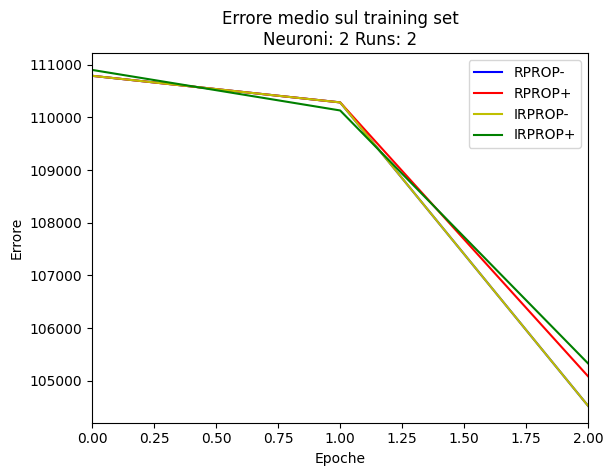

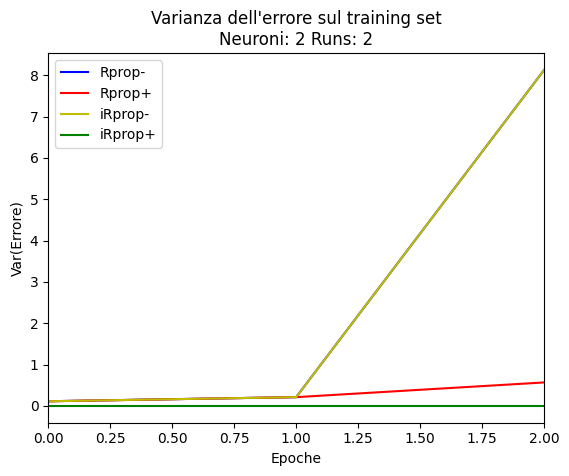

In [19]:
from matplotlib import pyplot as plt

# Stampo grafico dell'errore medio del train set
plt.figure()
plt.plot(std_metrics_mean[0], 'b', label='RPROP-')
plt.plot(plus_metrics_mean[0], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[0], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[0], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.title(f'Errore medio sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salvo il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_err_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampo grafico della varianza dell'errore del train set
plt.figure()
plt.plot(std_metrics_variance[0], 'b', label='RPROP-')
plt.plot(plus_metrics_variance[0], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[0], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[0], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Errore)')
plt.title(f'Varianza dell\'errore sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salvo il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_err_var_{number_of_runs}runs.png')

plt.show()

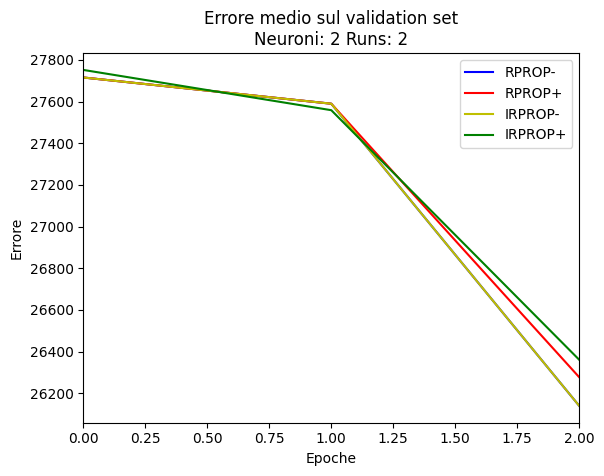

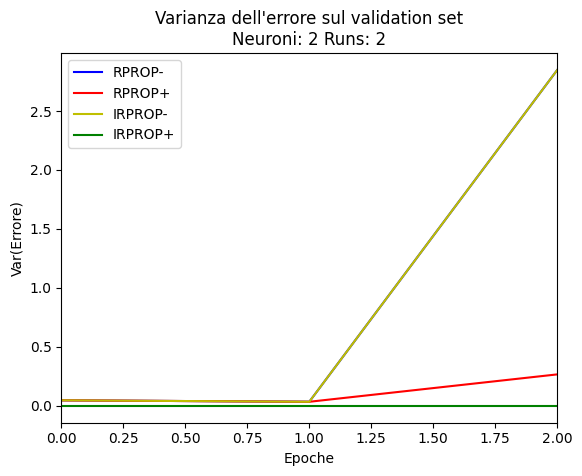

In [20]:
from matplotlib import pyplot as plt

# Stampa grafico dell'errore medio del validation set
plt.figure()
plt.plot(std_metrics_mean[1], 'b', label='RPROP-')
plt.plot(plus_metrics_mean[1], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[1], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[1], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.title(f'Errore medio sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_err_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampa grafico della varianza dell'errore del validation set
plt.figure()
plt.plot(std_metrics_variance[1], 'b', label='RPROP-')
plt.plot(plus_metrics_variance[1], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[1], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[1], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Errore)')
plt.title(f'Varianza dell\'errore sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_err_var_{number_of_runs}runs.png')

plt.show()

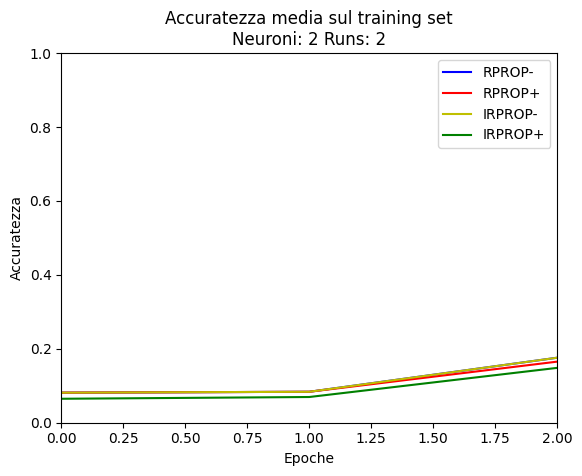

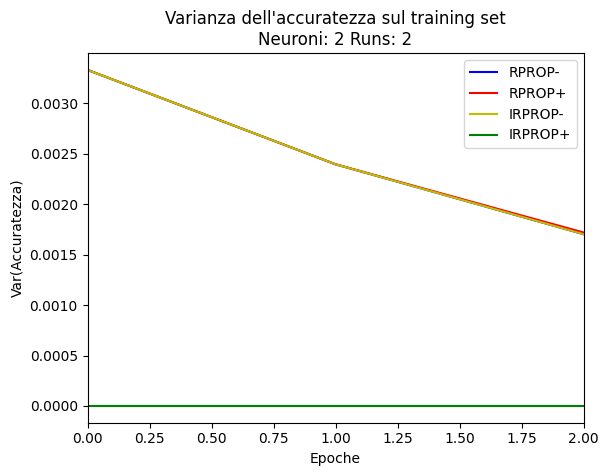

In [21]:
from matplotlib import pyplot as plt

# Stampa grafico dell'accuratezza media del train set
plt.figure()
plt.plot(std_metrics_mean[2], 'b', label='RPROP-')
plt.plot(plus_metrics_mean[2], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[2], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[2], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.title(f'Accuratezza media sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_acc_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampa grafico della varianza dell'accuratezza del train set
plt.figure()
plt.plot(std_metrics_variance[2], 'b', label='RPROP-')
plt.plot(plus_metrics_variance[2], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[2], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[2], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Accuratezza)')
plt.title(f'Varianza dell\'accuratezza sul training set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_train_acc_var_{number_of_runs}runs.png')

plt.show()

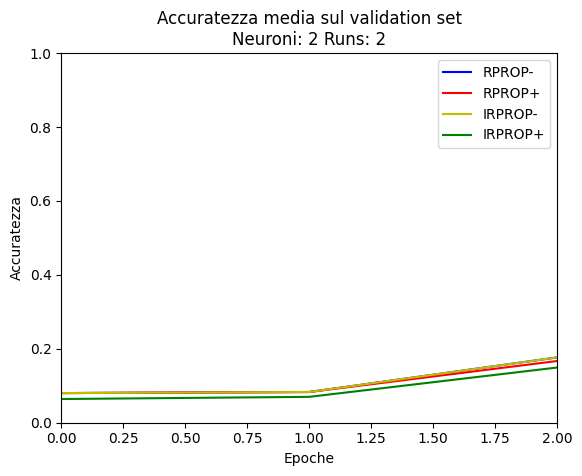

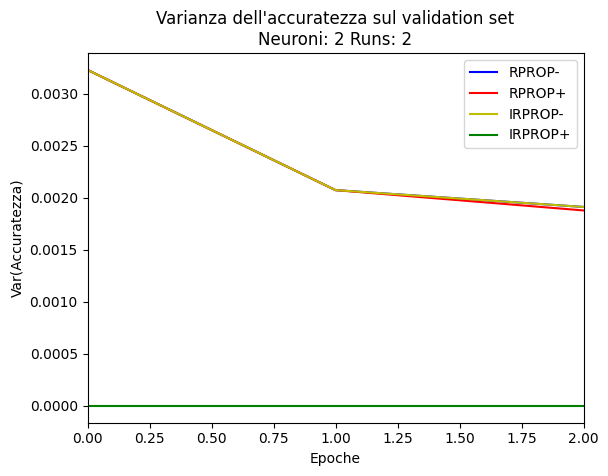

In [22]:
from matplotlib import pyplot as plt

# Stampa grafico dell'accuratezzaa media del validation set
plt.figure()
plt.plot(std_metrics_mean[3],  'b', label='RPROP-')
plt.plot(plus_metrics_mean[3], 'r', label='RPROP+')
plt.plot(istd_metrics_mean[3], 'y', label='IRPROP-')
plt.plot(iplus_metrics_mean[3], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.title(f'Accuratezza media sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_acc_mean_{number_of_runs}runs.png')

plt.show()
plt.close()


# Stampa grafico della varianza dell'accuratezza del validation set
plt.figure()
plt.plot(std_metrics_variance[3],  'b', label='RPROP-')
plt.plot(plus_metrics_variance[3], 'r', label='RPROP+')
plt.plot(istd_metrics_variance[3], 'y', label='IRPROP-')
plt.plot(iplus_metrics_variance[3], 'g', label='IRPROP+')
plt.xlabel('Epoche')
plt.ylabel('Var(Accuratezza)')
plt.title(f'Varianza dell\'accuratezza sul validation set\nNeuroni: {', '.join(map(str, hidden_layers))} Runs: {number_of_runs}')
plt.legend()
plt.xlim(0, epochs)

# Salva il plot come file PNG
plt.savefig(f'plots/{','.join(map(str, hidden_layers))}_val_acc_var_{number_of_runs}runs.png')

plt.show()

In [23]:
# Scrive le stringhe nel CSV
with open("data/runs_mean_variance.csv", "a") as file:
     file.write(csv_string_std)
     file.write(csv_string_plus)
     file.write(csv_string_istd)
     file.write(csv_string_iplus)

Test Rprop-
Probabilità predette dalla rete:
Classe 0: 0.16048361967805805
Classe 1: 0.09609890442671896
Classe 2: 0.05933988423474057
Classe 3: 0.06678505037188794
Classe 4: 0.09741918500778748
Classe 5: 0.09219476940488378
Classe 6: 0.15471381487197744
Classe 7: 0.10791791236707181
Classe 8: 0.0832229676518527
Classe 9: 0.08182389198502131


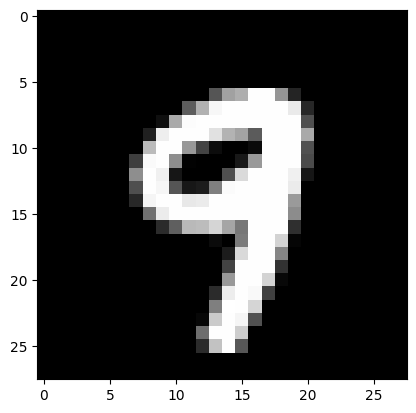

In [24]:
# Predizione rete addestrata con Rprop- (standard)
image = 8000

print('Test Rprop-')
std_training_net.test_prediction(image, test_in)

Test Rprop+
Probabilità predette dalla rete:
Classe 0: 0.39619458591573214
Classe 1: 0.03618647019231125
Classe 2: 0.011986209555186365
Classe 3: 0.010201750471166868
Classe 4: 0.05709508499558848
Classe 5: 0.0493902873115184
Classe 6: 0.3263348638597902
Classe 7: 0.06501179259584856
Classe 8: 0.02038168875316975
Classe 9: 0.027217266349687994


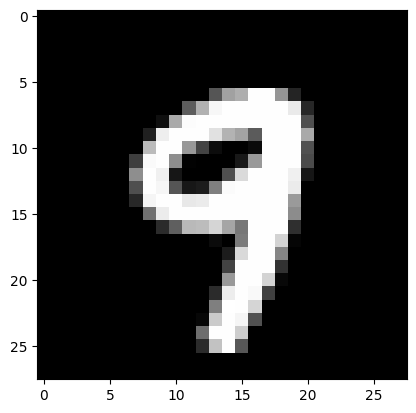

In [25]:
# Predizione rete addestrata con Rprop+ (Rprop con weight-backtracking)
image = 8000

print('Test Rprop+')
plus_training_net.test_prediction(image, test_in)

Test iRprop-
Probabilità predette dalla rete:
Classe 0: 0.16048361967805805
Classe 1: 0.09609890442671896
Classe 2: 0.05933988423474057
Classe 3: 0.06678505037188794
Classe 4: 0.09741918500778748
Classe 5: 0.09219476940488378
Classe 6: 0.15471381487197744
Classe 7: 0.10791791236707181
Classe 8: 0.0832229676518527
Classe 9: 0.08182389198502131


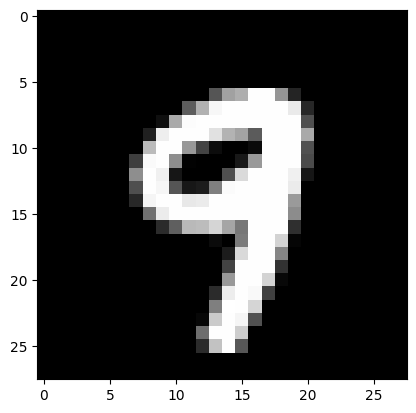

In [26]:
# Predizione rete addestrata con iRprop- (Improved Rprop)
image = 8000

print('Test iRprop-')
istd_training_net.test_prediction(image, test_in)

Test iRprop+
Probabilità predette dalla rete:
Classe 0: 0.39619458591573214
Classe 1: 0.03618647019231125
Classe 2: 0.011986209555186365
Classe 3: 0.010201750471166868
Classe 4: 0.05709508499558848
Classe 5: 0.0493902873115184
Classe 6: 0.3263348638597902
Classe 7: 0.06501179259584856
Classe 8: 0.02038168875316975
Classe 9: 0.027217266349687994


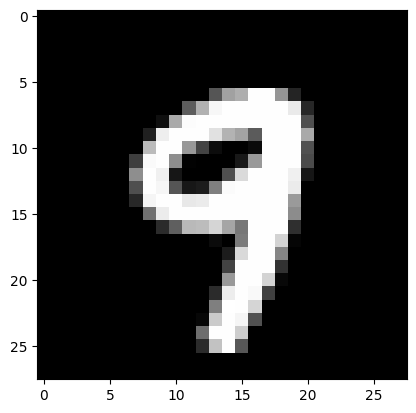

In [27]:
# Predizione rete addestrata con iRprop+ (Improved Rprop con weight-backtracking)
image = 8000

print('Test iRprop+')
iplus_training_net.test_prediction(image, test_in)